<a href="https://colab.research.google.com/github/Ganesh1829/Spam-detection-using-LSTM-based-Algorithms/blob/main/FINAL__Ganesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional


In [ ]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [ ]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [ ]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [ ]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

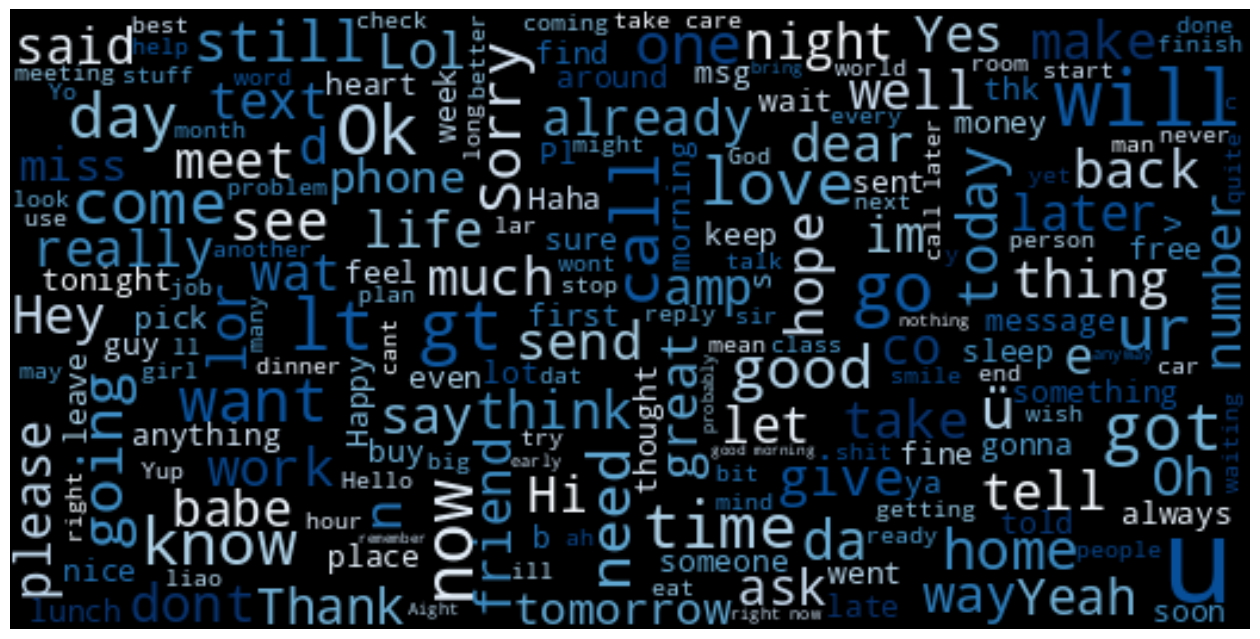

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

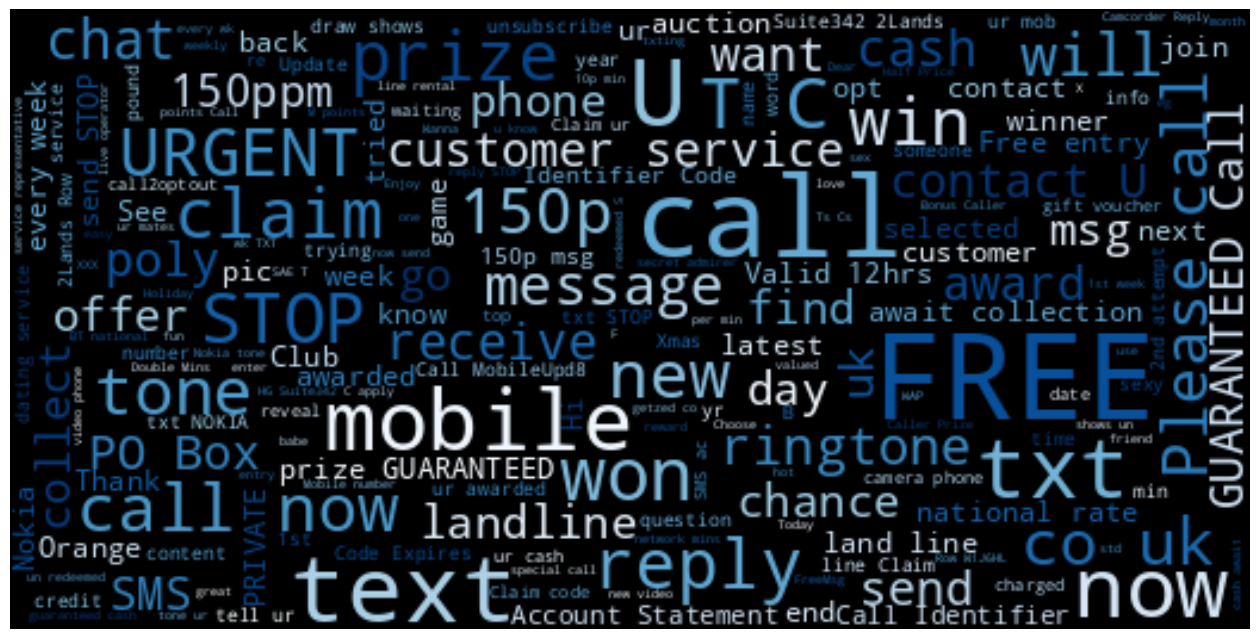

In [ ]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

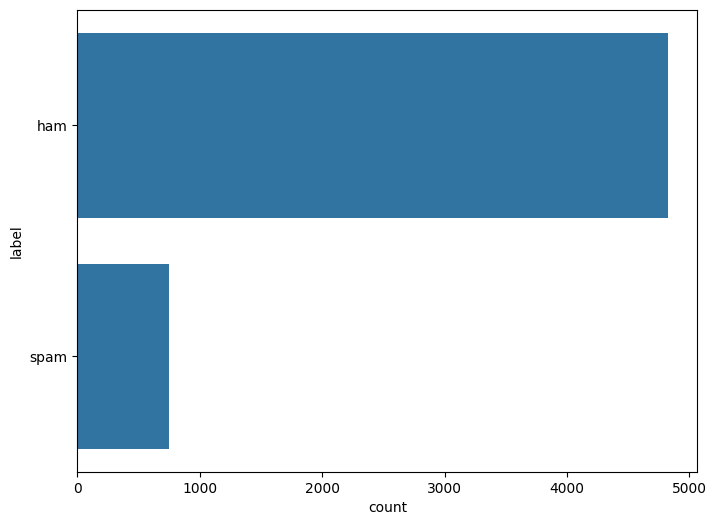

In [ ]:
# we can observe imbalance data here
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [ ]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

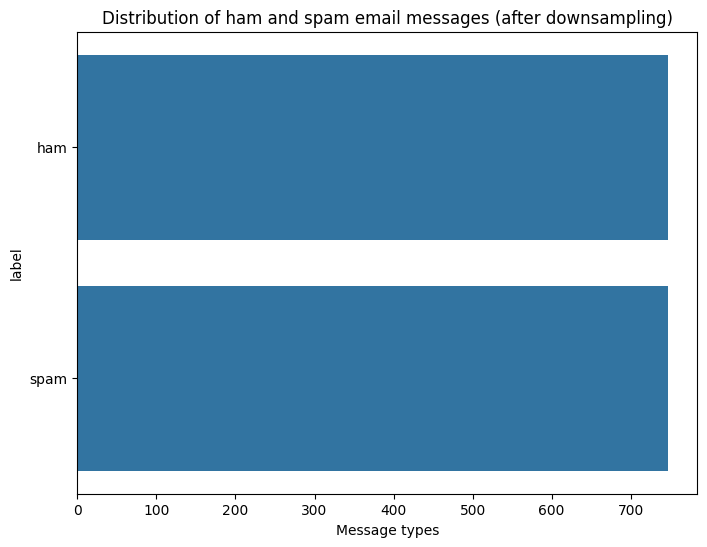

In [ ]:
# Create a dataframe with these ham and spam msg
msg_df = pd.concat([ham_msg_df, spam_msg_df]).reset_index(drop=True) # Use pd.concat to combine the dataframes
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [ ]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label')['text_length'].mean() # Select the 'text_length' column before calculating the mean
labels

label
ham      73.238286
spam    138.670683
Name: text_length, dtype: float64

In [ ]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [ ]:
# Defining pre-processing hyperparameters
max_len = 50
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
word_index



{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [ ]:
# check how many words
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [ ]:
# Sequencing and padding on training and testing
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [ ]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
len(training_sequences[0]), len(training_sequences[1])


(27, 24)

In [ ]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [ ]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8433 (32.94 KB)
Trainable params: 8433 (32.94 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [ ]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 3s - loss: 0.6829 - accuracy: 0.6059 - val_loss: 0.6682 - val_accuracy: 0.7759 - 3s/epoch - 80ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6446 - accuracy: 0.8460 - val_loss: 0.6187 - val_accuracy: 0.8127 - 289ms/epoch - 8ms/step
Epoch 3/30
38/38 - 0s - loss: 0.5770 - accuracy: 0.8686 - val_loss: 0.5433 - val_accuracy: 0.8428 - 169ms/epoch - 4ms/step
Epoch 4/30
38/38 - 0s - loss: 0.4905 - accuracy: 0.8762 - val_loss: 0.4618 - val_accuracy: 0.8562 - 349ms/epoch - 9ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4041 - accuracy: 0.8996 - val_loss: 0.3861 - val_accuracy: 0.8729 - 266ms/epoch - 7ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3311 - accuracy: 0.9029 - val_loss: 0.3290 - val_accuracy: 0.8863 - 335ms/epoch - 9ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2773 - accuracy: 0.9180 - val_loss: 0.2849 - val_accuracy: 0.8930 - 203ms/epoch - 5ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2365 - accuracy: 0.9322 - val_loss: 0.2475 - val_accuracy: 0.8963 - 291ms/epoch - 8ms/step
Epoch 9/30
38/38 -

In [ ]:
# Model performance on test data
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.9431


[0.11883029341697693, 0.9431437849998474]

In [ ]:
# Read as a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

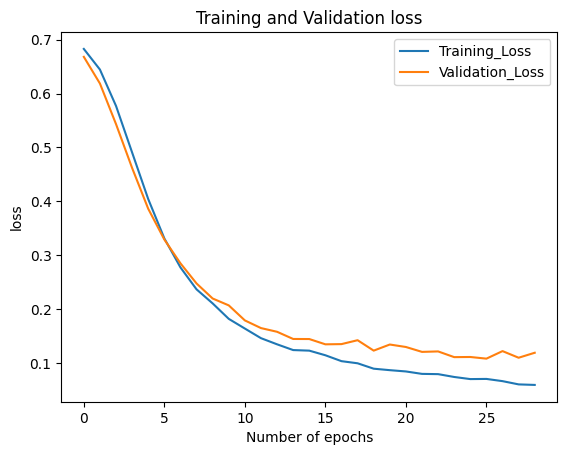

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')


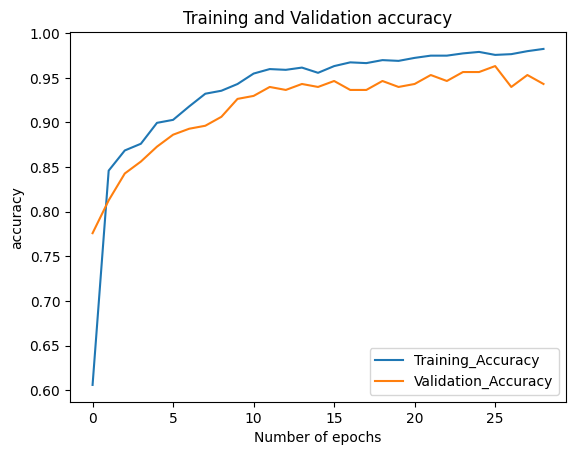

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


10/10 [==============================] - 0s 5ms/step


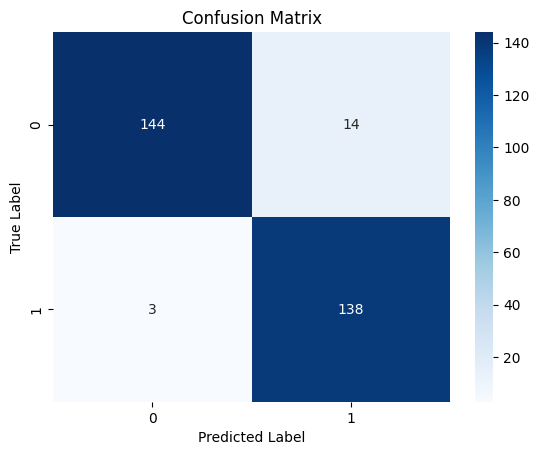

In [ ]:
from sklearn.metrics import confusion_matrix

# Get predictions from the model
predictions = model.predict(testing_padded)

# Round the predictions to 0 or 1
rounded_predictions = np.round(predictions)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [ ]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy']) # Add this line to compile the model

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 50, 1) vs (None,)).


In [ ]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=False)) # Change this line
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 8s - loss: 0.6914 - accuracy: 0.5264 - val_loss: 0.6716 - val_accuracy: 0.7726 - 8s/epoch - 211ms/step
Epoch 2/30
38/38 - 2s - loss: 0.4460 - accuracy: 0.8603 - val_loss: 0.3244 - val_accuracy: 0.8963 - 2s/epoch - 44ms/step
Epoch 3/30
38/38 - 2s - loss: 0.2370 - accuracy: 0.9230 - val_loss: 0.2492 - val_accuracy: 0.9164 - 2s/epoch - 55ms/step
Epoch 4/30
38/38 - 2s - loss: 0.1676 - accuracy: 0.9523 - val_loss: 0.1900 - val_accuracy: 0.9365 - 2s/epoch - 40ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1283 - accuracy: 0.9615 - val_loss: 0.1812 - val_accuracy: 0.9365 - 1s/epoch - 37ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1125 - accuracy: 0.9715 - val_loss: 0.1364 - val_accuracy: 0.9565 - 1s/epoch - 35ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0994 - accuracy: 0.9699 - val_loss: 0.1138 - val_accuracy: 0.9565 - 1s/epoch - 37ms/step
Epoch 8/30
38/38 - 1s - loss: 0.0771 - accuracy: 0.9799 - val_loss: 0.2256 - val_accuracy: 0.9331 - 1s/epoch - 37ms/step
Epoch 9/30
38/38 - 1s - loss: 0

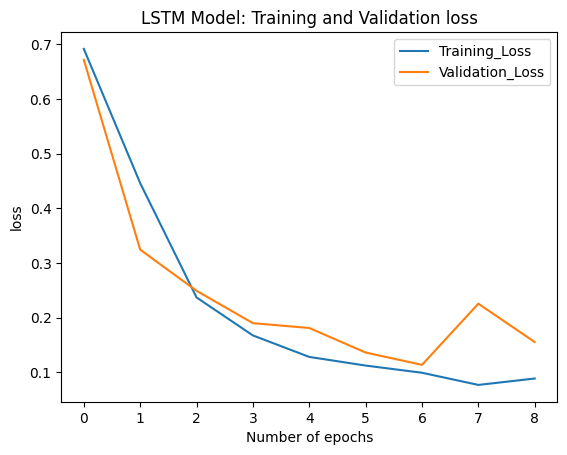

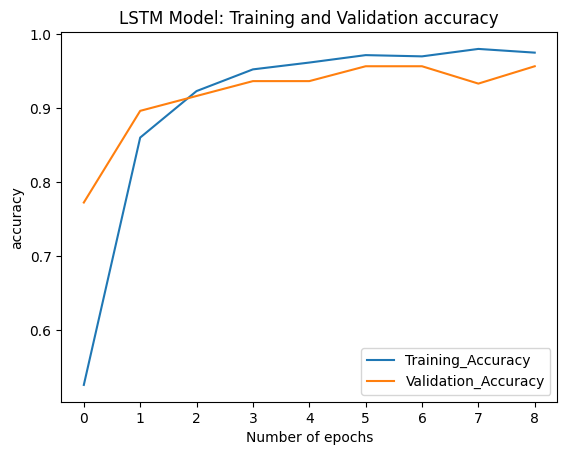

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

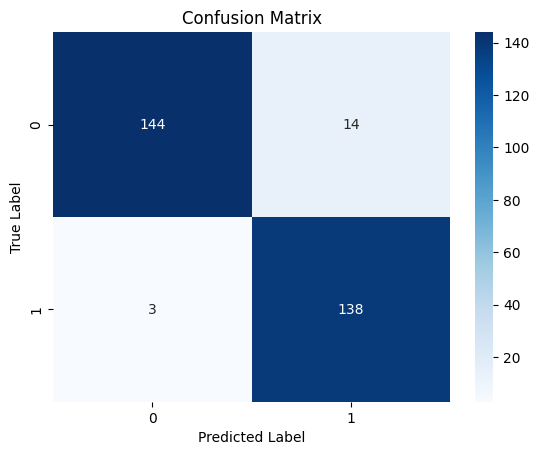

In [ ]:
# prompt: generate a confusion matrix

from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Biderectional LSTM Spam detection architecture
from keras.layers import GlobalMaxPooling1D # Import GlobalMaxPooling1D
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
# Add a GlobalMaxPooling1D layer to flatten the output of the LSTM
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy']) # Add this line to compile the model

# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs,
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 8s - loss: 0.6916 - accuracy: 0.5699 - val_loss: 0.6863 - val_accuracy: 0.6120 - 8s/epoch - 201ms/step
Epoch 2/30
38/38 - 1s - loss: 0.6471 - accuracy: 0.7766 - val_loss: 0.5034 - val_accuracy: 0.8997 - 1s/epoch - 31ms/step
Epoch 3/30
38/38 - 1s - loss: 0.4159 - accuracy: 0.9079 - val_loss: 0.3494 - val_accuracy: 0.9164 - 1s/epoch - 31ms/step
Epoch 4/30
38/38 - 1s - loss: 0.2958 - accuracy: 0.9464 - val_loss: 0.2768 - val_accuracy: 0.9197 - 1s/epoch - 31ms/step
Epoch 5/30
38/38 - 1s - loss: 0.2088 - accuracy: 0.9674 - val_loss: 0.2033 - val_accuracy: 0.9431 - 1s/epoch - 31ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1893 - accuracy: 0.9531 - val_loss: 0.2106 - val_accuracy: 0.9264 - 1s/epoch - 29ms/step
Epoch 7/30
38/38 - 1s - loss: 0.1383 - accuracy: 0.9715 - val_loss: 0.1459 - val_accuracy: 0.9532 - 1s/epoch - 29ms/step
Epoch 8/30
38/38 - 1s - loss: 0.1131 - accuracy: 0.9732 - val_loss: 0.1325 - val_accuracy: 0.9565 - 1s/epoch - 31ms/step
Epoch 9/30
38/38 - 1s - loss: 0

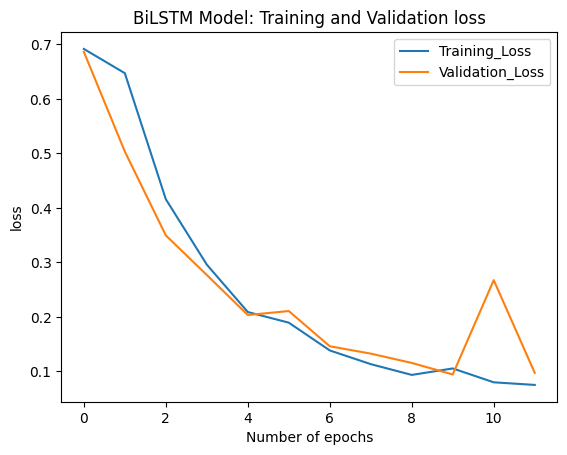

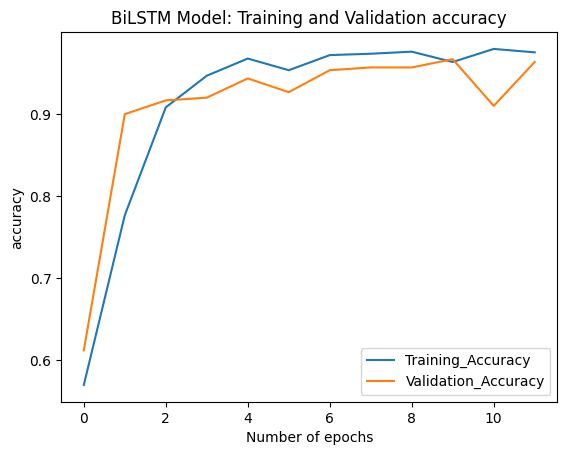

In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

10/10 [==============================] - 2s 8ms/step


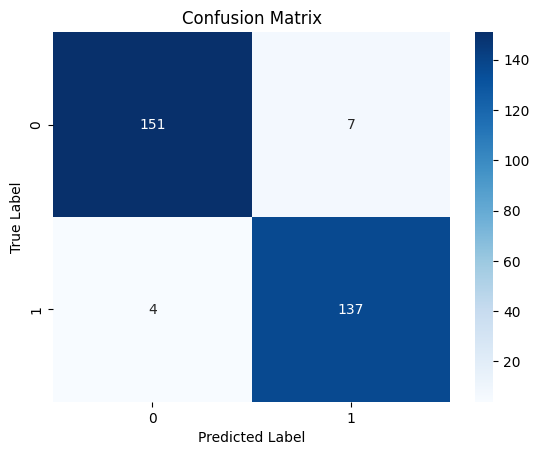

In [ ]:
# prompt: draw a confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from the model
predictions = model2.predict(testing_padded)

# Round the predictions to 0 or 1
rounded_predictions = np.round(predictions)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 0.9431
Dense architecture loss and accuracy: [0.11883029341697693, 0.9431437849998474] 
10/10 [==============================] - 0s 11ms/step - loss: 0.1555 - accuracy: 0.9565
LSTM architecture loss and accuracy: [0.15548110008239746, 0.95652174949646] 
10/10 [==============================] - 0s 9ms/step - loss: 0.0972 - accuracy: 0.9632
Bi-LSTM architecture loss and accuracy: [0.09719891101121902, 0.9632107019424438] 


In [ ]:
# display long string
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [ ]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 22ms/step


array([[0.0089298 ],
       [0.00585987],
       [0.9997674 ]], dtype=float32)

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["Dear Student, Your college invited you to the AICTE apna Career Portal. Explore career opportunities by activating your account now! Link: ct1.io/5zKBe6B ",
               "10 min left for webinar, Understanding Data Science & Analytics: Job Roles & Opportunities, to start. Join us live at 6 PM today. Dedicated Q&A round. Link to join: weurl.co/LEfsB9 Great Lakes",
          "Hii,How are you"]
predict_spam(predict_msg)

NameError: name 'predict_spam' is not defined